## Main Results

### Load Result

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jsonlines # Make sure you have this installed: pip install jsonlines

# Define your data dimensions
dataset_names = ["CommonsenseQA", "QASC", "MMLU-Pro-Law-100Q", "100TFQA", "GSM8K"]
model_names = ["Phi-3.5-mini-instruct", "Phi-3.5-vision-instruct", "Llama-3.1-8B", "Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "DeepSeek-R1-Distill-Llama-8B", "gpt-4o-2024-11-20"]
# Note: Ensure these match your file naming conventions (e.g., "zero-shot-cot" vs "Zero-shot CoT")
prompting_strategies_file = ["zero-shot", "zero-shot-cot", "few-shot", "few-shot-cot"]
# Mapping for display names in the plot legend
prompting_strategies_display = {
    "zero-shot": "Zero-shot",
    "zero-shot-cot": "Zero-shot CoT",
    "few-shot": "Few-shot",
    "few-shot-cot": "Few-shot CoT"
}

# --- Set your results directory here ---
result_dir = "../../../results" 
# Example: result_dir = "/Users/youruser/project/results"
# -------------------------------------

# Initialize matrices to store loaded data
accuracy_matrix = np.full((len(dataset_names), len(model_names), len(prompting_strategies_file)), -1.0) # Using -1 to indicate missing data
inconsistency_matrix = np.full((len(dataset_names), len(model_names), len(prompting_strategies_file)), -1.0) # Using -1 to indicate missing data

# Data loading loop
print("Loading data...")
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file):
            input_path = f"{result_dir}/{dataset_name}/{model_name}/{prompting_strategy_raw}_predictions.jsonl"
            try:
                with jsonlines.open(input_path) as fin:
                    accuracy_list, inconsistency_list = [], []
                    for example in fin.iter():
                        # The accuracy and consistency values are often nested, assuming 'mean' as per example
                        if "accuracy" in example and "mean" in example["accuracy"]:
                            accuracy_list.append(example["accuracy"]["mean"])
                        if "consistency" in example and "mean" in example["consistency"]:
                            # Inconsistency is 1 if consistency < 1, 0 otherwise
                            inconsistency_list.append(1.0 * (example["consistency"]["mean"] < 1))
                    
                    # Calculate mean, handle cases where lists might be empty
                    # If lists are empty (e.g., file was empty or parsing failed to find data), assign -1
                    mean_accuracy = np.mean(accuracy_list) if accuracy_list else -1.0
                    mean_inconsistency = np.mean(inconsistency_list) if inconsistency_list else -1.0

                    accuracy_matrix[i][j][k] = mean_accuracy
                    inconsistency_matrix[i][j][k] = mean_inconsistency
            except FileNotFoundError:
                # print(f"File not found: {input_path}")
                pass # Matrix is already initialized with -1
            except Exception as e:
                # print(f"Error processing {input_path}: {e}")
                pass # Matrix is already initialized with -1
print("Data loading complete.")

Loading data...
Data loading complete.


### Impact of Multimodal Training

In [48]:
# fontsize_title = 30
fontsize_xylabel = 24
# fontsize_text = 14

/tmp/ipykernel_631709/3205046510.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


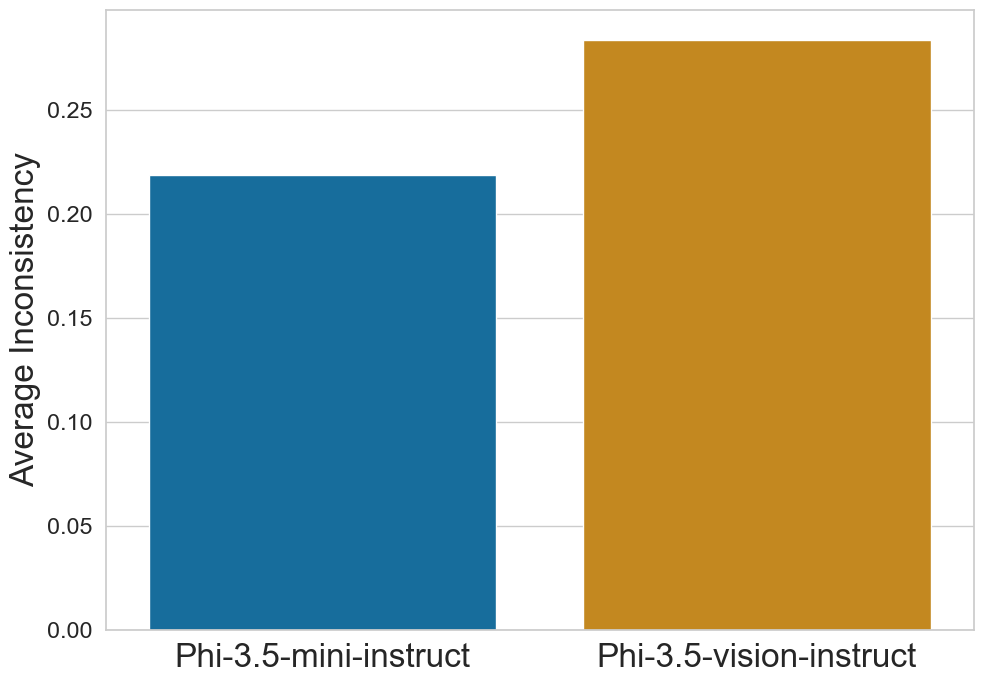

In [80]:
# Prepare data for plotting - AVERAGE INCONSISTENCY PER TASK (ACROSS ALL MODELS AND STRATEGIES)
plot_data_all_models_strategies = []
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names): # Iterate through all models
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file): # Iterate through all prompting strategies
            incons = inconsistency_matrix[i][j][k]
            
            # Only include if the value is valid (not -1, which indicates missing data)
            if incons != -1.0:
                plot_data_all_models_strategies.append({
                    'Task': dataset_name,
                    'Model': model_name, # Keep for intermediate data, though not used in final aggregation
                    'Prompting Strategy': prompting_strategies_display[prompting_strategy_raw], # Keep for intermediate data
                    'Inconsistency': incons
                })

df_all_data = pd.DataFrame(plot_data_all_models_strategies)

# Now, average across all models and prompting strategies for each task
df_aggregated_by_task = df_all_data.groupby('Model').agg(
    Mean_Inconsistency=('Inconsistency', 'mean'),
    Std_Inconsistency=('Inconsistency', 'std')
).reset_index()

# Handle cases where std might be NaN if only one data point was available for a task (set to 0 for plotting)
df_aggregated_by_task['Std_Inconsistency'] = df_aggregated_by_task['Std_Inconsistency'].fillna(0)

# Define the desired order of tasks (optional, uses dataset_names order by default)
desired_task_order = ["Phi-3.5-mini-instruct", "Phi-3.5-vision-instruct"]

# Convert 'Task' to a categorical type with the specified order
df_aggregated_by_task['Model'] = pd.Categorical(
    df_aggregated_by_task['Model'],
    categories=desired_task_order,
    ordered=True
)

# Sort the DataFrame by the new categorical order
df = df_aggregated_by_task.sort_values('Model')


# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7)) # Adjusted figure size for 5 bars

# Create the bar plot for average inconsistency per task
ax = sns.barplot(
    data=df,
    x="Model",
    y="Mean_Inconsistency",
    # yerr=df["Std_Inconsistency"], # Add error bars for standard deviation
    palette="colorblind", # Using a different palette
    edgecolor="white",
    linewidth=1,
    capsize=0.1 # Add caps to the error bars
)

# Add titles and labels
# ax.set_title('Impact of Multimodal Training on Inconsistency', fontsize=fontsize_title)
ax.set_xlabel("", fontsize=fontsize_xylabel)
ax.set_ylabel("Average Inconsistency", fontsize=fontsize_xylabel)

# Adjust x-axis and y-axis tick label font sizes
ax.tick_params(axis='x', labelsize=fontsize_xylabel)
ax.tick_params(axis='y', labelsize=fontsize_xylabel*0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

plt.show()

### Impact of Instruction Tuning

/tmp/ipykernel_631709/31010.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


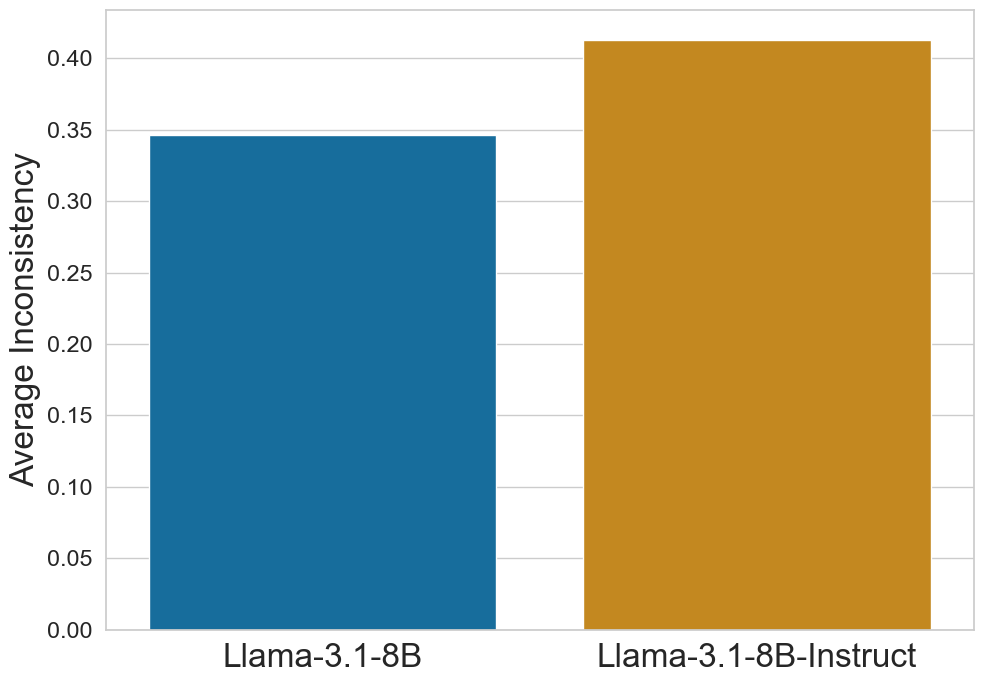

In [81]:
# Prepare data for plotting - AVERAGE INCONSISTENCY PER TASK (ACROSS ALL MODELS AND STRATEGIES)
plot_data_all_models_strategies = []
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names): # Iterate through all models
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file): # Iterate through all prompting strategies
            incons = inconsistency_matrix[i][j][k]
            
            # Only include if the value is valid (not -1, which indicates missing data)
            if incons != -1.0:
                plot_data_all_models_strategies.append({
                    'Task': dataset_name,
                    'Model': model_name, # Keep for intermediate data, though not used in final aggregation
                    'Prompting Strategy': prompting_strategies_display[prompting_strategy_raw], # Keep for intermediate data
                    'Inconsistency': incons
                })

df_all_data = pd.DataFrame(plot_data_all_models_strategies)

# Now, average across all models and prompting strategies for each task
df_aggregated_by_task = df_all_data.groupby('Model').agg(
    Mean_Inconsistency=('Inconsistency', 'mean'),
    Std_Inconsistency=('Inconsistency', 'std')
).reset_index()

# Handle cases where std might be NaN if only one data point was available for a task (set to 0 for plotting)
df_aggregated_by_task['Std_Inconsistency'] = df_aggregated_by_task['Std_Inconsistency'].fillna(0)

# Define the desired order of tasks (optional, uses dataset_names order by default)
desired_task_order = ["Llama-3.1-8B", "Llama-3.1-8B-Instruct"]

# Convert 'Task' to a categorical type with the specified order
df_aggregated_by_task['Model'] = pd.Categorical(
    df_aggregated_by_task['Model'],
    categories=desired_task_order,
    ordered=True
)

# Sort the DataFrame by the new categorical order
df = df_aggregated_by_task.sort_values('Model')


# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7)) # Adjusted figure size for 5 bars

# Create the bar plot for average inconsistency per task
ax = sns.barplot(
    data=df,
    x="Model",
    y="Mean_Inconsistency",
    # yerr=df["Std_Inconsistency"], # Add error bars for standard deviation
    palette="colorblind", # Using a different palette
    edgecolor="white",
    linewidth=1,
    capsize=0.1 # Add caps to the error bars
)

# Add titles and labels
# ax.set_title('Impact of Instruction Tuning on Inconsistency', fontsize=fontsize_title)
ax.set_xlabel("", fontsize=fontsize_xylabel)
ax.set_ylabel("Average Inconsistency", fontsize=fontsize_xylabel)

# Adjust x-axis and y-axis tick label font sizes
ax.tick_params(axis='x', labelsize=fontsize_xylabel)
ax.tick_params(axis='y', labelsize=fontsize_xylabel*0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

plt.show()

/tmp/ipykernel_631709/1124147198.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


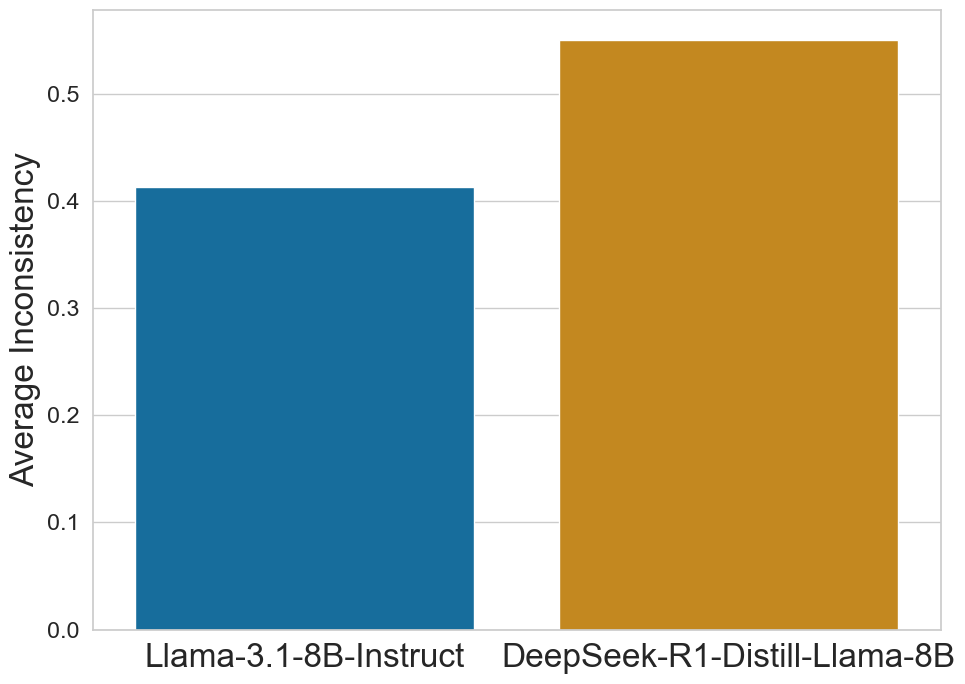

In [82]:
# Prepare data for plotting - AVERAGE INCONSISTENCY PER TASK (ACROSS ALL MODELS AND STRATEGIES)
plot_data_all_models_strategies = []
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names): # Iterate through all models
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file): # Iterate through all prompting strategies
            incons = inconsistency_matrix[i][j][k]
            
            # Only include if the value is valid (not -1, which indicates missing data)
            if incons != -1.0:
                plot_data_all_models_strategies.append({
                    'Task': dataset_name,
                    'Model': model_name, # Keep for intermediate data, though not used in final aggregation
                    'Prompting Strategy': prompting_strategies_display[prompting_strategy_raw], # Keep for intermediate data
                    'Inconsistency': incons
                })

df_all_data = pd.DataFrame(plot_data_all_models_strategies)

# Now, average across all models and prompting strategies for each task
df_aggregated_by_task = df_all_data.groupby('Model').agg(
    Mean_Inconsistency=('Inconsistency', 'mean'),
    Std_Inconsistency=('Inconsistency', 'std')
).reset_index()

# Handle cases where std might be NaN if only one data point was available for a task (set to 0 for plotting)
df_aggregated_by_task['Std_Inconsistency'] = df_aggregated_by_task['Std_Inconsistency'].fillna(0)

# Define the desired order of tasks (optional, uses dataset_names order by default)
desired_task_order = ["Llama-3.1-8B-Instruct", "DeepSeek-R1-Distill-Llama-8B"]

# Convert 'Task' to a categorical type with the specified order
df_aggregated_by_task['Model'] = pd.Categorical(
    df_aggregated_by_task['Model'],
    categories=desired_task_order,
    ordered=True
)

# Sort the DataFrame by the new categorical order
df = df_aggregated_by_task.sort_values('Model')


# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7)) # Adjusted figure size for 5 bars

# Create the bar plot for average inconsistency per task
ax = sns.barplot(
    data=df,
    x="Model",
    y="Mean_Inconsistency",
    # yerr=df["Std_Inconsistency"], # Add error bars for standard deviation
    palette="colorblind", # Using a different palette
    edgecolor="white",
    linewidth=1,
    capsize=0.1 # Add caps to the error bars
)

# Add titles and labels
# ax.set_title('Impact of Distillation on Inconsistency', fontsize=fontsize_title)
ax.set_xlabel("", fontsize=fontsize_xylabel)
ax.set_ylabel("Average Inconsistency", fontsize=fontsize_xylabel)


# Adjust x-axis and y-axis tick label font sizes
ax.tick_params(axis='x', labelsize=fontsize_xylabel)
ax.tick_params(axis='y', labelsize=fontsize_xylabel*0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

plt.show()

### Comparison between Tasks

/tmp/ipykernel_631709/463841802.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


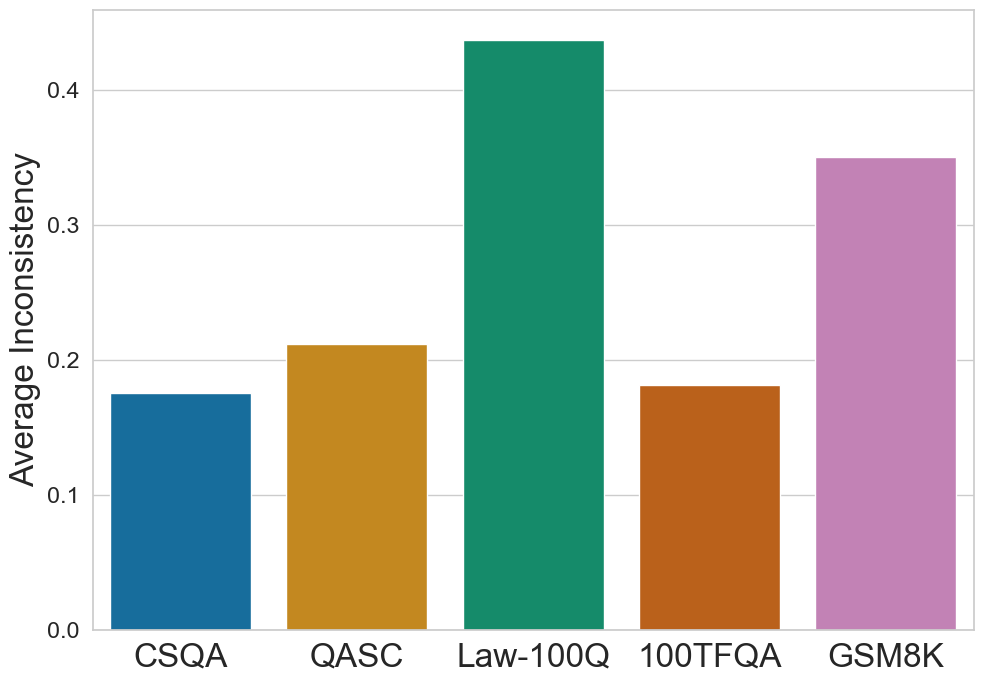

In [86]:
# Prepare data for plotting - AVERAGE INCONSISTENCY PER TASK (ACROSS ALL MODELS AND STRATEGIES)
plot_data_all_models_strategies = []
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names): # Iterate through all models
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file): # Iterate through all prompting strategies
            incons = inconsistency_matrix[i][j][k]
            
            # Only include if the value is valid (not -1, which indicates missing data)
            if incons != -1.0:
                dataset_name = dataset_name if "MMLU-Pro-Law-100Q" not in dataset_name else "Law-100Q"
                dataset_name = dataset_name if "CommonsenseQA" not in dataset_name else "CSQA"
                plot_data_all_models_strategies.append({
                    'Task': dataset_name,
                    'Model': model_name, # Keep for intermediate data, though not used in final aggregation
                    'Prompting Strategy': prompting_strategies_display[prompting_strategy_raw], # Keep for intermediate data
                    'Inconsistency': incons
                })

df_all_data = pd.DataFrame(plot_data_all_models_strategies)

# Now, average across all models and prompting strategies for each task
df_aggregated_by_task = df_all_data.groupby('Task').agg(
    Mean_Inconsistency=('Inconsistency', 'mean'),
    Std_Inconsistency=('Inconsistency', 'std')
).reset_index()

# Handle cases where std might be NaN if only one data point was available for a task (set to 0 for plotting)
df_aggregated_by_task['Std_Inconsistency'] = df_aggregated_by_task['Std_Inconsistency'].fillna(0)

# Define the desired order of tasks (optional, uses dataset_names order by default)
desired_task_order = ["CSQA", "QASC", "Law-100Q", "100TFQA", "GSM8K"]

# Convert 'Task' to a categorical type with the specified order
df_aggregated_by_task['Task'] = pd.Categorical(
    df_aggregated_by_task['Task'],
    categories=desired_task_order,
    ordered=True
)

# Sort the DataFrame by the new categorical order
df = df_aggregated_by_task.sort_values('Task')


# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7)) # Adjusted figure size for 5 bars

# Create the bar plot for average inconsistency per task
ax = sns.barplot(
    data=df,
    x="Task",
    y="Mean_Inconsistency",
    # yerr=df["Std_Inconsistency"], # Add error bars for standard deviation
    palette="colorblind", # Using a different palette
    edgecolor="white",
    linewidth=1,
    capsize=0.1 # Add caps to the error bars
)

# Add titles and labels
# ax.set_title('Average Inconsistency Across Tasks', fontsize=fontsize_title)
ax.set_xlabel("", fontsize=fontsize_xylabel)
ax.set_ylabel("Average Inconsistency", fontsize=fontsize_xylabel)

# Adjust x-axis and y-axis tick label font sizes
ax.tick_params(axis='x', labelsize=fontsize_xylabel)
ax.tick_params(axis='y', labelsize=fontsize_xylabel*0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

plt.show()


### Comparison between Prompting Strategies

/tmp/ipykernel_631709/4127280591.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


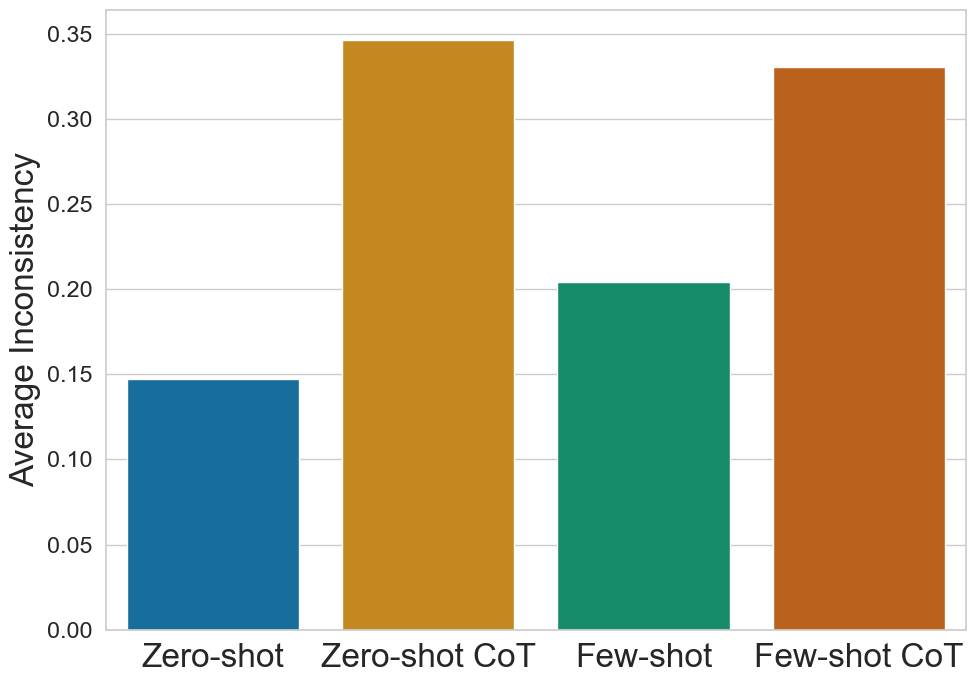

In [87]:
# Prepare data for plotting - AVERAGE INCONSISTENCY PER TASK (ACROSS ALL MODELS AND STRATEGIES)
plot_data_all_models_strategies = []
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names): # Iterate through all models
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file): # Iterate through all prompting strategies
            incons = inconsistency_matrix[i][j][k]
            
            # Only include if the value is valid (not -1, which indicates missing data)
            if incons != -1.0:
                plot_data_all_models_strategies.append({
                    'Task': dataset_name,
                    'Model': model_name, # Keep for intermediate data, though not used in final aggregation
                    'Prompting Strategy': prompting_strategies_display[prompting_strategy_raw], # Keep for intermediate data
                    'Inconsistency': incons
                })

df_all_data = pd.DataFrame(plot_data_all_models_strategies)

# Now, average across all models and prompting strategies for each task
df_aggregated_by_task = df_all_data.groupby('Prompting Strategy').agg(
    Mean_Inconsistency=('Inconsistency', 'mean'),
    Std_Inconsistency=('Inconsistency', 'std')
).reset_index()

# Handle cases where std might be NaN if only one data point was available for a task (set to 0 for plotting)
df_aggregated_by_task['Std_Inconsistency'] = df_aggregated_by_task['Std_Inconsistency'].fillna(0)

# Define the desired order of tasks (optional, uses dataset_names order by default)
desired_task_order = ["Zero-shot", "Zero-shot CoT", "Few-shot", "Few-shot CoT"]

# Convert 'Task' to a categorical type with the specified order
df_aggregated_by_task['Prompting Strategy'] = pd.Categorical(
    df_aggregated_by_task['Prompting Strategy'],
    categories=desired_task_order,
    ordered=True
)

# Sort the DataFrame by the new categorical order
df = df_aggregated_by_task.sort_values('Prompting Strategy')


# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7)) # Adjusted figure size for 5 bars

# Create the bar plot for average inconsistency per task
ax = sns.barplot(
    data=df,
    x="Prompting Strategy",
    y="Mean_Inconsistency",
    # yerr=df["Std_Inconsistency"], # Add error bars for standard deviation
    palette="colorblind", # Using a different palette
    edgecolor="white",
    linewidth=1,
    capsize=0.1 # Add caps to the error bars
)

# Add titles and labels
# ax.set_title('Average Inconsistency Across Prompting Strategies', fontsize=fontsize_title)
ax.set_xlabel("", fontsize=fontsize_xylabel)
ax.set_ylabel("Average Inconsistency", fontsize=fontsize_xylabel)

# Adjust x-axis and y-axis tick label font sizes
ax.tick_params(axis='x', labelsize=fontsize_xylabel)
ax.tick_params(axis='y', labelsize=fontsize_xylabel*0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

plt.show()


### Comparison between Models

/tmp/ipykernel_631709/2421878438.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


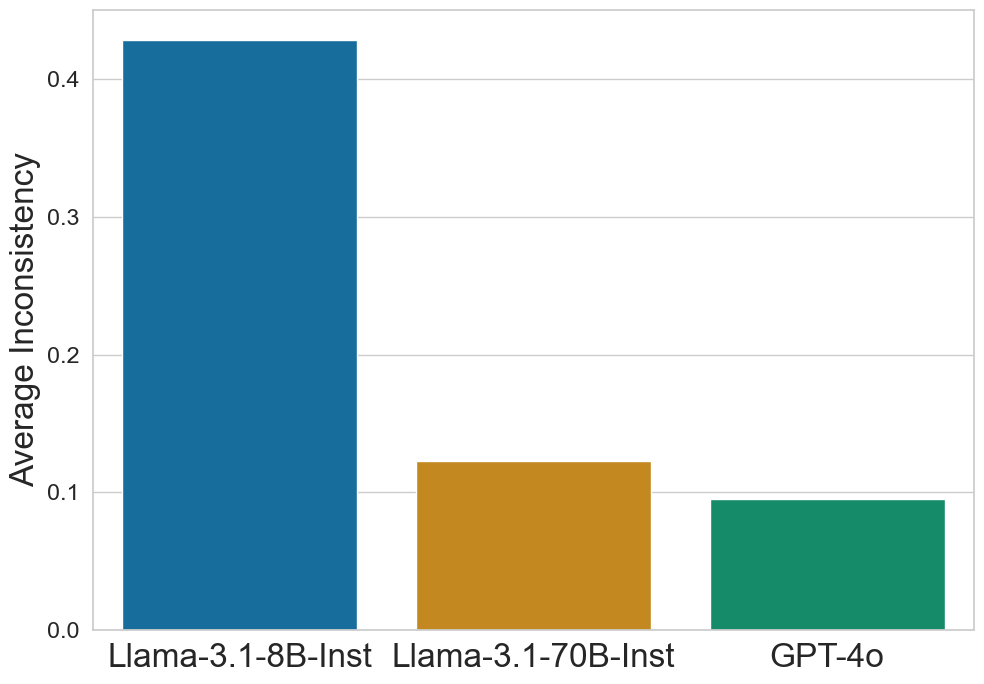

In [88]:
# Prepare data for plotting - AVERAGE INCONSISTENCY PER TASK (ACROSS ALL MODELS AND STRATEGIES)
plot_data_all_models_strategies = []
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names): # Iterate through all models
        for k, prompting_strategy_raw in enumerate(prompting_strategies_file): # Iterate through all prompting strategies
            incons = inconsistency_matrix[i][j][k]
            
            # Only include if the value is valid (not -1, which indicates missing data)
            if incons != -1.0:
                model_name = model_name if "8B" not in model_name else "Llama-3.1-8B-Inst"
                model_name = model_name if "70B" not in model_name else "Llama-3.1-70B-Inst"
                model_name = model_name if "gpt-4o" not in model_name else "GPT-4o"
                plot_data_all_models_strategies.append({
                    'Task': dataset_name,
                    'Model': model_name, # Keep for intermediate data, though not used in final aggregation
                    'Prompting Strategy': prompting_strategies_display[prompting_strategy_raw], # Keep for intermediate data
                    'Inconsistency': incons
                })

df_all_data = pd.DataFrame(plot_data_all_models_strategies)

# Now, average across all models and prompting strategies for each task
df_aggregated_by_task = df_all_data.groupby('Model').agg(
    Mean_Inconsistency=('Inconsistency', 'mean'),
    Std_Inconsistency=('Inconsistency', 'std')
).reset_index()

# Handle cases where std might be NaN if only one data point was available for a task (set to 0 for plotting)
df_aggregated_by_task['Std_Inconsistency'] = df_aggregated_by_task['Std_Inconsistency'].fillna(0)

# Define the desired order of tasks (optional, uses dataset_names order by default)
desired_task_order = ["Llama-3.1-8B-Inst", "Llama-3.1-70B-Inst", "GPT-4o"]

# Convert 'Task' to a categorical type with the specified order
df_aggregated_by_task['Model'] = pd.Categorical(
    df_aggregated_by_task['Model'],
    categories=desired_task_order,
    ordered=True
)

# Sort the DataFrame by the new categorical order
df = df_aggregated_by_task.sort_values('Model')


# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7)) # Adjusted figure size for 5 bars

# Create the bar plot for average inconsistency per task
ax = sns.barplot(
    data=df,
    x="Model",
    y="Mean_Inconsistency",
    # yerr=df["Std_Inconsistency"], # Add error bars for standard deviation
    palette="colorblind", # Using a different palette
    edgecolor="white",
    linewidth=1,
    capsize=0.1 # Add caps to the error bars
)

# Add titles and labels
# ax.set_title('Average Inconsistency Across Model Sizes', fontsize=fontsize_title)
ax.set_xlabel("", fontsize=fontsize_xylabel)
ax.set_ylabel("Average Inconsistency", fontsize=fontsize_xylabel)

# # Add text labels on top of each bar
# for i, bar in enumerate(ax.patches):
#     mean_val = df['Mean_Inconsistency'].iloc[i]
#     std_val = df['Std_Inconsistency'].iloc[i]
    
#     # Position for the text, considering error bars
#     # Adjust vertical alignment based on positive/negative value
#     if mean_val >= 0:
#         text_y_pos = bar.get_height() + 0.001 # Above the error bar top
#         va_align = 'bottom'
#     else:
#         text_y_pos = bar.get_height() - 0.001 # Below the error bar bottom
#         va_align = 'top'

#     ax.text(bar.get_x() + bar.get_width() / 2, text_y_pos,
#             # f'{mean_val:.3f} ± {std_val:.3f}', # Format to 3 decimal places with std
#             f'{mean_val:.3f}',
#             ha='center', va=va_align,
#             fontsize=fontsize_text, color='black')

# Adjust x-axis and y-axis tick label font sizes
ax.tick_params(axis='x', labelsize=fontsize_xylabel)
ax.tick_params(axis='y', labelsize=fontsize_xylabel*0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

plt.show()


## Main table

In [23]:
dataset_names = ["CommonsenseQA", "QASC", "MMLU-Pro-Law-100Q", "100TFQA", "GSM8K"]
model_names = ["Phi-3.5-mini-instruct", "Phi-3.5-vision-instruct", "Llama-3.1-8B", "Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "DeepSeek-R1-Distill-Llama-8B", "gpt-4o-2024-11-20"]
prompting_strategies = ["zero-shot", "zero-shot-cot", "few-shot", "few-shot-cot"]

accuracy_matrix, inconsistency_matrix = np.zeros((len(dataset_names), len(model_names), len(prompting_strategies))), np.zeros((len(dataset_names), len(model_names), len(prompting_strategies)))
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        for k, prompting_strategy in enumerate(prompting_strategies):
            # Read score file
            input_path = f"{result_dir}/{dataset_name}/{model_name}/{prompting_strategy}_predictions.jsonl"
            try:
                with jsonlines.open(input_path) as fin:
                    accuracy_list, inconsistency_list = [], []
                    for example in fin.iter():
                        accuracy_list.append(example["accuracy"]["mean"])
                        inconsistency_list.append(1.0*(example["consistency"]["mean"] < 1))
                    mean_accuracy = np.mean(accuracy_list)
                    mean_inconsistency = np.mean(inconsistency_list)

                    accuracy_matrix[i][j][k] = mean_accuracy
                    inconsistency_matrix[i][j][k] = mean_inconsistency
            except Exception as e:
                # print(k, e)
                accuracy_matrix[i][j][k] = -1
                inconsistency_matrix[i][j][k] = -1
                # exit(0)

prompting_strategies = ["Zero-shot", "Zero-shot CoT", "Few-shot", "Few-shot CoT"]
# Create LaTeX table string
latex_code = "\\begin{table*}[t]\n"
latex_code += "\\centering\n"
latex_code += "\\begin{tabular}{c|c|cccc}\n"
latex_code += "\\toprule\n"
latex_code += "Task & Model & " + " & ".join(prompting_strategies) + " \\\\\n"
latex_code += "\\midrule\\midrule\n"

# Fill the table with data
for task_idx, task in enumerate(dataset_names):
    latex_code += f"\\multirow{{7}}{{*}}{{{task}}}\n"
    for model_idx, model in enumerate(model_names):
        latex_code += "      "
        latex_code += f"& {model} "
        for strat_idx in range(len(prompting_strategies)):
            acc = round(accuracy_matrix[task_idx, model_idx, strat_idx], 2)
            inc = round(inconsistency_matrix[task_idx, model_idx, strat_idx], 2)

            # Skip conditions
            if acc < 0:
                latex_code += f"& - "
                continue
            if model == "Llama-3.1-8B" and "Zero-shot" in prompting_strategies[strat_idx]:
                latex_code += f"& - "
                continue
            if model == "DeepSeek-R1-Distill-Llama-8B" and "CoT" not in prompting_strategies[strat_idx]:
                latex_code += f"& - "
                continue

            # Base idx setting
            base_idx = 1 if task in ["GSM8K"] else 0
            if model == "Llama-3.1-8B":
                base_idx = 3 if task in ["GSM8K"] else 2
            if model == "DeepSeek-R1-Distill-Llama-8B":
                base_idx = 1

            base_acc = round(accuracy_matrix[task_idx, model_idx, base_idx], 2)
            base_inc = round(inconsistency_matrix[task_idx, model_idx, base_idx], 2)
            acc_str = f"{acc:.2f}"
            inc_str = f"{inc:.2f}"
            # if acc > base_acc:
            #     acc_str = "\\blue{" + acc_str + "}"
            # elif acc < base_acc:
            #     acc_str = "\\red{" + acc_str + "}"
            # if inc < base_inc:
            #     inc_str = "\\blue{" + inc_str + "}"
            # elif inc > base_inc:
            #     inc_str = "\\red{" + inc_str + "}"
            latex_code += f"& {acc_str} | {inc_str} "
        latex_code += "\\\\\n"
    latex_code += "\\midrule\n"

# Close LaTeX table
latex_code = latex_code.rstrip("\\midrule\n")  # Remove last midrule
latex_code += "\\\\\n"
latex_code += "\\bottomrule\n"
latex_code += "\\end{tabular}\n"
latex_code += "\\caption{Mean accuracy (left) and setwise inconsistency (right) across different tasks, models and prompting strategies. Blue values indicate performance improvement over zero-shot (or the leftmost strategy if not available), while red values denote performance drop.}\n"
latex_code += "\\label{tab:accuracy_inconsistency}\n"
latex_code += "\\end{table*}"

# Display the generated LaTeX table code
print(latex_code)

with open("accuracy_inconsistency_table.txt", "w") as fout:
    fout.write(latex_code)

\begin{table*}[t]
\centering
\begin{tabular}{c|c|cccc}
\toprule
Task & Model & Zero-shot & Zero-shot CoT & Few-shot & Few-shot CoT \\
\midrule\midrule
\multirow{7}{*}{CommonsenseQA}
      & Phi-3.5-mini-instruct & 0.75 | 0.10 & 0.76 | 0.21 & 0.73 | 0.10 & - \\
      & Phi-3.5-vision-instruct & 0.76 | 0.09 & 0.73 | 0.30 & 0.74 | 0.10 & - \\
      & Llama-3.1-8B & - & - & 0.72 | 0.11 & - \\
      & Llama-3.1-8B-Instruct & 0.75 | 0.10 & 0.76 | 0.25 & 0.68 | 0.51 & - \\
      & Llama-3.1-70B-Instruct & 0.82 | 0.04 & 0.84 | 0.12 & 0.80 | 0.26 & - \\
      & DeepSeek-R1-Distill-Llama-8B & - & 0.68 | 0.51 & - & - \\
      & gpt-4o-2024-11-20 & 0.85 | 0.07 & 0.84 | 0.08 & 0.87 | 0.04 & - \\
\midrule
\multirow{7}{*}{QASC}
      & Phi-3.5-mini-instruct & 0.76 | 0.09 & 0.79 | 0.16 & 0.77 | 0.10 & 0.82 | 0.17 \\
      & Phi-3.5-vision-instruct & 0.75 | 0.11 & 0.77 | 0.29 & 0.76 | 0.10 & 0.77 | 0.20 \\
      & Llama-3.1-8B & - & - & 0.78 | 0.10 & 0.69 | 0.32 \\
      & Llama-3.1-8B-Instruct & 0.82 

## Mitigation

### Self-consistency (majority voting)

In [ ]:
dataset_names = ["CommonsenseQA", "QASC", "100TFQA", "GSM8K"]
# model_names = ["Phi-3.5-mini-instruct", "Phi-3.5-vision-instruct", "Llama-3.1-8B", "Llama-3.1-8B-Instruct", "DeepSeek-R1-Distill-Llama-8B", "gpt-4o-2024-11-20"]
model_names = ["Llama-3.1-8B-Instruct", "gpt-4o-2024-11-20"]
prompting_strategies = ["zero-shot", "zero-shot-cot", "few-shot", "few-shot-cot"]

accuracy_matrix, inconsistency_matrix = np.zeros((len(dataset_names), len(model_names), len(prompting_strategies))), np.zeros((len(dataset_names), len(model_names), len(prompting_strategies)))
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        for k, prompting_strategy in enumerate(prompting_strategies):
            # Read score file
            input_path = f"{result_dir}/{dataset_name}/{model_name}/{prompting_strategy}_majority_voting_predictions.jsonl"
            try:
                with jsonlines.open(input_path) as fin:
                    accuracy_list, inconsistency_list = [], []
                    for example in fin.iter():
                        accuracy_list.append(example["accuracy"]["mean"])
                        inconsistency_list.append(1.0*(example["consistency"]["mean"] < 1))
                    mean_accuracy = np.mean(accuracy_list)
                    mean_inconsistency = np.mean(inconsistency_list)

                    accuracy_matrix[i][j][k] = mean_accuracy
                    inconsistency_matrix[i][j][k] = mean_inconsistency
            except Exception as e:
                # print(k, e)
                accuracy_matrix[i][j][k] = -1
                inconsistency_matrix[i][j][k] = -1
                # exit(0)

prompting_strategies = ["Zero-shot", "Zero-shot CoT", "Few-shot", "Few-shot CoT"]
# Create LaTeX table string
latex_code = ""

# Fill the table with data
for task_idx, task in enumerate(dataset_names):
    latex_code += f"\\multirow{{6}}{{*}}{{{task}}}\n"
    for model_idx, model in enumerate(model_names):
        latex_code += "      "
        latex_code += f"& {model} + Self-consistency "
        for strat_idx in range(len(prompting_strategies)):
            acc = round(accuracy_matrix[task_idx, model_idx, strat_idx], 2)
            inc = round(inconsistency_matrix[task_idx, model_idx, strat_idx], 2)

            # Skip conditions
            if acc < 0:
                latex_code += f"& - "
                continue

            acc_str = f"{acc:.2f}"
            inc_str = f"{inc:.2f}"
            latex_code += f"& {acc_str} | {inc_str} "
        latex_code += "\\\\\n"
    latex_code += "\\midrule\n"

# Display the generated LaTeX table code
print(latex_code)

with open("accuracy_inconsistency_table_self_consistency.txt", "w") as fout:
    fout.write(latex_code)

### Reference-guided

In [ ]:
# dataset_names = ["CommonsenseQA", "QASC", "100TFQA", "GSM8K"]
dataset_names = ["QASC"]
# model_names = ["Phi-3.5-mini-instruct", "Phi-3.5-vision-instruct", "Llama-3.1-8B", "Llama-3.1-8B-Instruct", "DeepSeek-R1-Distill-Llama-8B", "gpt-4o-2024-11-20"]
model_names = ["Llama-3.1-8B-Instruct", "gpt-4o-2024-11-20"]
prompting_strategies = ["zero-shot", "zero-shot-cot", "few-shot", "few-shot-cot"]

accuracy_matrix, inconsistency_matrix = np.zeros((len(dataset_names), len(model_names), len(prompting_strategies))), np.zeros((len(dataset_names), len(model_names), len(prompting_strategies)))
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        for k, prompting_strategy in enumerate(prompting_strategies):
            # Read score file
            input_path = f"{result_dir}/{dataset_name}/{model_name}/{prompting_strategy}-reference-guided_predictions.jsonl"
            try:
                with jsonlines.open(input_path) as fin:
                    accuracy_list, inconsistency_list = [], []
                    for example in fin.iter():
                        accuracy_list.append(example["accuracy"]["mean"])
                        inconsistency_list.append(1.0*(example["consistency"]["mean"] < 1))
                    mean_accuracy = np.mean(accuracy_list)
                    mean_inconsistency = np.mean(inconsistency_list)

                    accuracy_matrix[i][j][k] = mean_accuracy
                    inconsistency_matrix[i][j][k] = mean_inconsistency
            except Exception as e:
                # print(k, e)
                accuracy_matrix[i][j][k] = -1
                inconsistency_matrix[i][j][k] = -1
                # exit(0)

prompting_strategies = ["Zero-shot", "Zero-shot CoT", "Few-shot", "Few-shot CoT"]
# Create LaTeX table string
latex_code = ""

# Fill the table with data
for task_idx, task in enumerate(dataset_names):
    latex_code += f"\\multirow{{6}}{{*}}{{{task}}}\n"
    for model_idx, model in enumerate(model_names):
        latex_code += "      "
        latex_code += f"& {model} + Reference-guided "
        for strat_idx in range(len(prompting_strategies)):
            if strat_idx > 0:
                latex_code += f"& - "
                continue
            acc = round(accuracy_matrix[task_idx, model_idx, strat_idx], 2)
            inc = round(inconsistency_matrix[task_idx, model_idx, strat_idx], 2)

            # Skip conditions
            if acc < 0:
                latex_code += f"& - "
                continue

            acc_str = f"{acc:.2f}"
            inc_str = f"{inc:.2f}"
            latex_code += f"& {acc_str} | {inc_str} "
        latex_code += "\\\\\n"
    latex_code += "\\midrule\n"

# Display the generated LaTeX table code
print(latex_code)

# with open("accuracy_inconsistency_table_reference_guided.txt", "w") as fout:
#     fout.write(latex_code)